In [198]:
import pandas as pd
import numpy as np
import yaml
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import openpyxl
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score,precision_score, f1_score
import xgboost as xgb
import optuna
import talib
import json
import pickle

In [199]:
def load_yaml(file):
    import yaml
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config
    



In [200]:
config = load_yaml('../config.yaml')

In [201]:
trading_data = pd.read_excel(config['data_excel_path'], sheet_name='Data_Basic')
trading_data.count()

Date      2504
Open      2504
High      2504
Low       2504
Close     2504
Volume    2504
dtype: int64

In [202]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data
    

In [203]:
def add_new_features_df(data):
    data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    # Add the time of day feature to the trading data
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'])
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'])

    return data

In [204]:
trading_data - add_new_features_df(trading_data)
trading_data = trading_data.dropna()
trading_data.reset_index(drop=True, inplace=True)
trading_data.head()

,Date,Open,High,Low,Close,Volume,BOLLBU,BOLLBM,BOLLBL,DONUP,...,SI,WASI,VOLMA,ATR,ADJATR,DayofWeek,Minutes_Passed,TimeOfDay_Group,Sine_TimeOfDay,Cosine_TimeOfDay
0,2024-12-02 14:10:00,603.5600,603.58,603.120,603.1900,185074,603.910464,603.634680,603.358896,603.8799,...,-9.208333,-9.208333,143431.6,0.255893,0.268867,0,850,170,-2.742714e-14,1.0
1,2024-12-02 14:15:00,603.1800,603.37,603.050,603.2000,250452,603.948908,603.614180,603.279452,603.8799,...,-1.208333,-1.208333,159477.9,0.260472,0.266456,0,855,171,-4.898835e-14,1.0
2,2024-12-02 14:20:00,603.1950,603.30,603.090,603.2787,176197,603.953177,603.592115,603.231053,603.8799,...,2.092500,2.092500,164874.8,0.256867,0.264236,0,860,172,-7.054956e-14,1.0
3,2024-12-02 14:25:00,603.2600,603.48,603.145,603.4000,135747,603.938732,603.575115,603.211498,603.8799,...,3.537083,3.537083,168340.5,0.262448,0.262888,0,865,173,-9.211077e-14,1.0
4,2024-12-02 14:30:00,603.4101,603.69,603.390,603.5899,120093,603.919550,603.566360,603.213170,603.8799,...,5.246667,5.246667,156713.5,0.265130,0.262227,0,870,174,-1.136720e-13,1.0


In [205]:
trading_data['DayofWeek'] = trading_data['Date'].dt.dayofweek


print(trading_data.head())


                 Date      Open    High      Low     Close  Volume  \
0 2024-12-02 14:10:00  603.5600  603.58  603.120  603.1900  185074   
1 2024-12-02 14:15:00  603.1800  603.37  603.050  603.2000  250452   
2 2024-12-02 14:20:00  603.1950  603.30  603.090  603.2787  176197   
3 2024-12-02 14:25:00  603.2600  603.48  603.145  603.4000  135747   
4 2024-12-02 14:30:00  603.4101  603.69  603.390  603.5899  120093   

       BOLLBU      BOLLBM      BOLLBL     DONUP  ...        SI      WASI  \
0  603.910464  603.634680  603.358896  603.8799  ... -9.208333 -9.208333   
1  603.948908  603.614180  603.279452  603.8799  ... -1.208333 -1.208333   
2  603.953177  603.592115  603.231053  603.8799  ...  2.092500  2.092500   
3  603.938732  603.575115  603.211498  603.8799  ...  3.537083  3.537083   
4  603.919550  603.566360  603.213170  603.8799  ...  5.246667  5.246667   

      VOLMA       ATR    ADJATR  DayofWeek  Minutes_Passed  TimeOfDay_Group  \
0  143431.6  0.255893  0.268867          0 

In [207]:
trading_data['Take_Profit_Level'] = trading_data['Close'] + (trading_data['Close'] * config['atr_multiplier'] * trading_data['ADJATR'])
print(trading_data.head())

                 Date      Open    High      Low     Close  Volume  \
0 2024-12-02 14:10:00  603.5600  603.58  603.120  603.1900  185074   
1 2024-12-02 14:15:00  603.1800  603.37  603.050  603.2000  250452   
2 2024-12-02 14:20:00  603.1950  603.30  603.090  603.2787  176197   
3 2024-12-02 14:25:00  603.2600  603.48  603.145  603.4000  135747   
4 2024-12-02 14:30:00  603.4101  603.69  603.390  603.5899  120093   

       BOLLBU      BOLLBM      BOLLBL     DONUP  ...      WASI     VOLMA  \
0  603.910464  603.634680  603.358896  603.8799  ... -9.208333  143431.6   
1  603.948908  603.614180  603.279452  603.8799  ... -1.208333  159477.9   
2  603.953177  603.592115  603.231053  603.8799  ...  2.092500  164874.8   
3  603.938732  603.575115  603.211498  603.8799  ...  3.537083  168340.5   
4  603.919550  603.566360  603.213170  603.8799  ...  5.246667  156713.5   

        ATR    ADJATR  DayofWeek  Minutes_Passed  TimeOfDay_Group  \
0  0.255893  0.268867          0             850     

In [208]:
def calculate_label(data):
    data['Label'] = 'H'
    for i in range(len(data)):
        stop_loss_level = data['Close'][i] - ((data['Take_Profit_Level'][i] - data['Close'][i]) * config['risk'])
        for j in range(1, config['bars_no_to_wait']):
            if i+j < len(data):
                if data['High'][i+j] >= data['Take_Profit_Level'][i]:
                    data.iloc[i, data.columns.get_loc('Label')] = 'B'
                    break
                elif data['Low'][i+j] < stop_loss_level:
                    data.iloc[i, data.columns.get_loc('Label')] = 'S'
                    break
    return data

In [209]:
trading_data = calculate_label(trading_data)

In [210]:
trading_data.value_counts('Label')

Label
H    2015
S     326
B      64
Name: count, dtype: int64

In [211]:
#trading_data['Date'] = pd.to_datetime(trading_data['Date'])
fig = go.Figure(data=[go.Candlestick(x=trading_data['Date'], open=trading_data['Open'], high=trading_data['High'], low=trading_data['Low'], close=trading_data['Close'])])
fig.update_layout(title='CandleStick Chart SPY', xaxis_title='Date', yaxis_title='Price', xaxis_rangeslider_visible=False, yaxis=dict(fixedrange=False), xaxis=dict(type='category'))
buy_signals = trading_data[trading_data['Label'] == 'B']
sell_signals = trading_data[trading_data['Label'] == 'S']
fig.add_trace(go.Scatter(x=buy_signals['Date'], y=buy_signals['Low'], mode='markers', name='Buy Signal', marker=dict(color='blue', size=10)))
fig.add_trace(go.Scatter(x=sell_signals['Date'], y=sell_signals['High'], mode='markers', name='Sell Signal', marker=dict(color='yellow', size=10)))
fig.show()

In [129]:
def compute_fourier_transform(data, n_components=10):
    fft_values = fft(data)
    fft_real = np.real(fft_values[:n_components])
    fft_imag = np.imag(fft_values[:n_components])
    fft_mag = np.abs(fft_values[:n_components])
    #print("Hello")
    return np.hstack([fft_real, fft_imag, fft_mag])


In [179]:
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']
def get_features(data):
    # need to use min max scaler for g1
    raw_features_g1 = config['raw_features_g1'].split(',')
    print(raw_features_g1)

    #g2 is the other features. need to use standard scaler for this
    raw_features_g2 = config['raw_features_g2'].split(',')

    #g3 is volume features. need to use min max scaler separately
    raw_features_g3 = config['raw_features_g3'].split(',')

    raw_features_g4 = config['raw_features_g4'].split(',')

    #print(data[raw_features_g1].head())
    #print(data[raw_features_g1].dtypes)
    global_min_g1 = data[raw_features_g1].min().min()
    global_max_g1 = data[raw_features_g1].max().max()

    #Apply min max scaler to g1
    if (global_max_g1 - global_min_g1) == 0:
        print("Divide by 0 coming")
    data[raw_features_g1] = (data[raw_features_g1] - global_min_g1) / (global_max_g1 - global_min_g1)


    # Apply standard scaler to g2
    print("Before standard scaler")
    scaler = StandardScaler()
    data[raw_features_g2] = scaler.fit_transform(data[raw_features_g2])
    print("After standard scaler")

    with open('../Saved_Data/g2_standard_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    eps = 1e-5
    data[raw_features_g3] = np.log(data[raw_features_g3] + eps)

    # Apply min max scaler to g3
    global_min_g3 = data[raw_features_g3].min().min()
    global_max_g3 = data[raw_features_g3].max().max()
    if (global_max_g3 - global_min_g3) == 0:
        print("2 Divide by 0 coming")
        
    data[raw_features_g3] = (data[raw_features_g3] - global_min_g3) / (global_max_g3 - global_min_g3)

    minmax_scaling_params = {
        'g1': {'min': global_min_g1, 'max': global_max_g1},
        'g3': {'min': global_min_g3, 'max': global_max_g3}
    }

    with open('../Saved_Data/minmax_scaling_params.json', 'w') as f:
        json.dump(minmax_scaling_params, f)
        
    # Add one hot encoding for dayofweek column
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories=[range(7)])
    encoded_days = encoder.fit_transform(data[['DayofWeek']])
    encoded_days_df = pd.DataFrame(encoded_days, columns=[f'Day_{i}' for i in range(7)])
    data = pd.concat([data, encoded_days_df], axis=1)
    features = []
    epsilon = 1e-5
    for end in range( fourier_lookback_window, len(data)+1, 1):
        #print(f"end is : {end}")
        close_window = data['Close'].iloc[end-fourier_lookback_window:end].values

        #volume_window = data['Volume'].iloc[end-fourier_lookback_window:end].values

        # Calculate percentage changes for the Close values in the window
        pct_close_window = ((close_window - close_window[0]) / close_window[0])
        #log_volume_window = np.log(volume_window + epsilon)
        #pct_volume_window = np.diff(log_volume_window) * 100
        fourier_close_features = compute_fourier_transform(pct_close_window, n_components=fourier_n_components)
        fourier_min = fourier_close_features.min()
        fourier_max = fourier_close_features.max()
        fourier_close_features = (fourier_close_features - fourier_min) / (fourier_max - fourier_min)
        #fourier_volume_features = compute_fourier_transform(pct_volume_window, n_components=fourier_n_components)

        raw_features_g1_df = data[raw_features_g1].iloc[end-1].values
        raw_features_g2_df = data[raw_features_g2].iloc[end-1].values
        raw_features_g3_df = data[raw_features_g3].iloc[end-1].values
        raw_features_g4_df = data[raw_features_g4].iloc[end-1].values

        day_of_week_df = data[[f'Day_{i}' for i in range(7)]].iloc[end-1].values

        #combine all features
        combined_features = np.hstack([fourier_close_features, raw_features_g1_df, raw_features_g2_df, raw_features_g3_df, raw_features_g4_df, day_of_week_df])
        features.append(combined_features)

    close_columns = [f'Close_FFT_Real_{i}' for i in range(fourier_n_components)] + \
    [f'Close_FFT_Imag_{i}' for i in range(fourier_n_components)] + \
    [f'Close_FFT_Mag_{i}' for i in range(fourier_n_components)]

    volume_columns = [f'Volume_FFT_Real_{i}' for i in range(fourier_n_components)] + \
    [f'Volume_FFT_Imag_{i}' for i in range(fourier_n_components)] + \
    [f'Volume_FFT_Mag_{i}' for i in range(fourier_n_components)]


    #feature_columns = close_columns + raw_features_g1 + raw_features_g2 + raw_features_g3 + raw_features_g4 + [f'Day_{i}' for i in range(7)]
    #df_features = pd.DataFrame(features, columns=feature_columns)
    #output_excel_path = '../temp_data/input_features.xlsx'
    #df_features.to_excel(output_excel_path, index=False)


    features = np.array(features)
    return features

In [180]:
#raw_features_g1
trading_features = get_features(trading_data)

['Open', 'High', 'Low', 'Close', 'BOLLBU', 'BOLLBM', 'BOLLBL', 'DONUP', 'DONMID', 'DONLOW', 'MA20', 'MA50', 'MA100', 'EMA20', 'PVPTR1', 'PVPTR2', 'PVPTR3', 'PVPT', 'PVPTS1', 'PVPTS2', 'PVPTS3', 'TCHR']
Before standard scaler
After standard scaler


In [132]:
print(trading_features.shape)

(2306, 67)


In [143]:
dbscan = DBSCAN(eps=1.425, min_samples=10, n_jobs=3)
dbscan_labels = dbscan.fit_predict(trading_features)

# Add labels to the features for visualization
features_with_labels = np.hstack([trading_features, dbscan_labels.reshape(-1, 1)])
print(np.unique(dbscan_labels))


[-1  0  1  2  3]


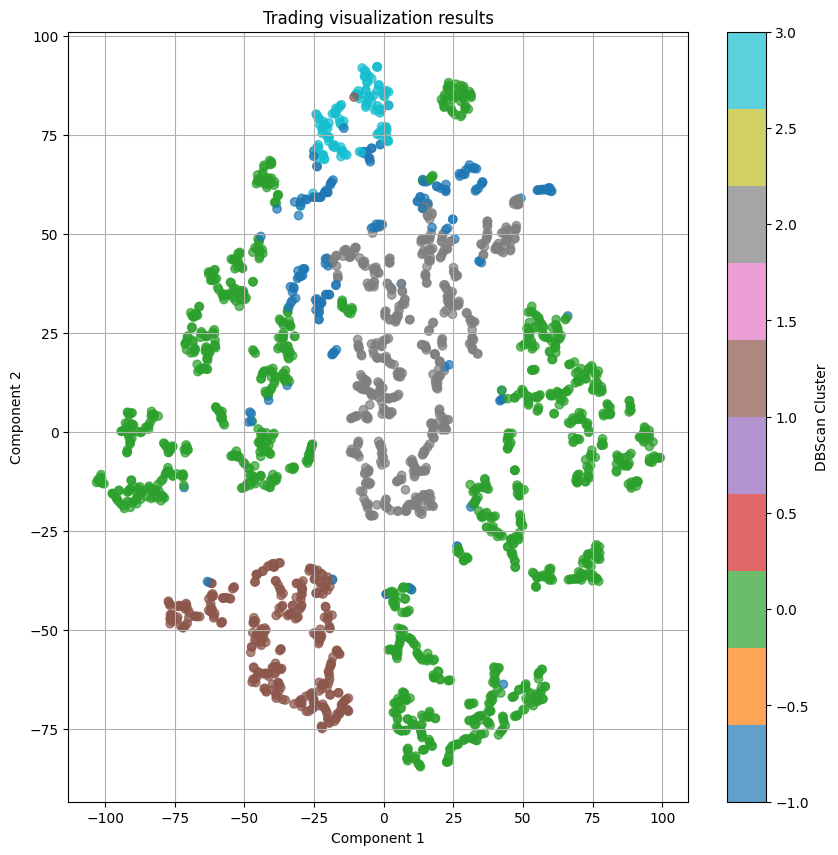

In [144]:
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)
tsne_results = tsne.fit_transform(trading_features)

# Add tsne results to the features for visualization
plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='DBScan Cluster')
plt.title("Trading visualization results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()


In [145]:
f_lookback = config['fourier_lookback_window']

In [146]:
trading_data.iloc[f_lookback:]['Label'].value_counts()

Label
H    1921
S     321
B      63
Name: count, dtype: int64

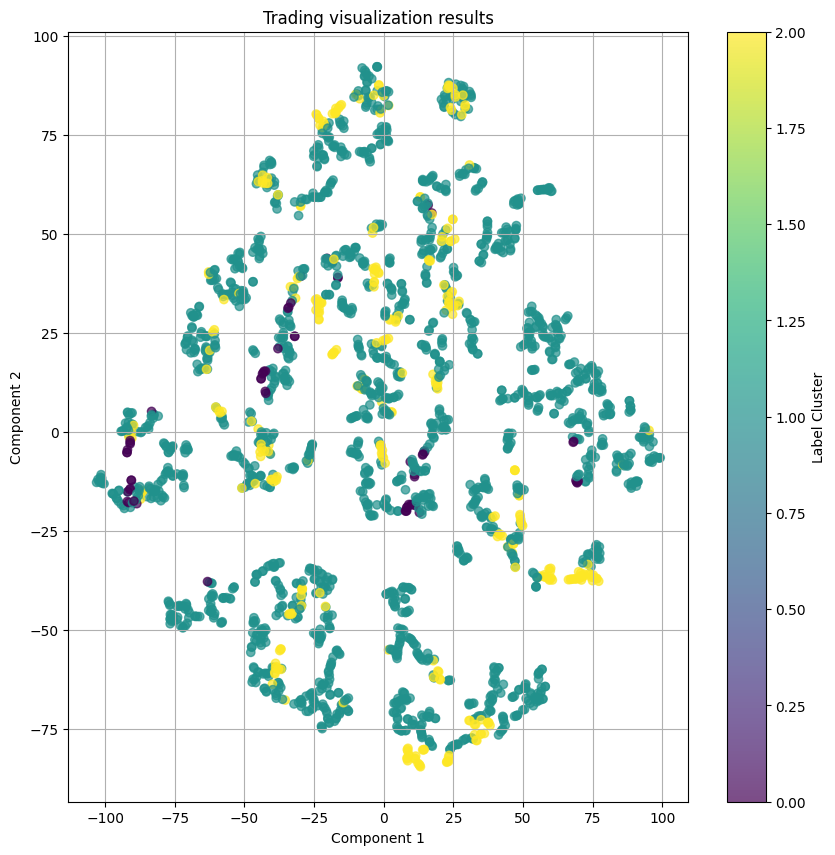

In [147]:
labels_cat = trading_data.iloc[f_lookback-1:]['Label'].values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_cat)
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)
tsne_results = tsne.fit_transform(trading_features)

# Add tsne results to the features for visualization
plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Label Cluster')
plt.title("Trading visualization results")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()


In [188]:
trading_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [213]:
labels = trading_data['Label'].iloc[fourier_lookback_window-1:].reset_index(drop=True)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

with open('../Saved_Data/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [154]:


assert trading_features.shape[0] == labels_encoded.shape[0], "Mismatch between features and labels length"

X_train, X_temp, Y_train, Y_temp = train_test_split(trading_features, labels_encoded, test_size=0.3, random_state=46)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=46)


In [155]:
#xgb_classifier = XGBClassifier(use_label_encoder=False,eval_metrics='mlogloss', random_state=46)

#convert data to d matrix to use with xgb
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_valid, label=Y_valid)
dtest = xgb.DMatrix(X_test, label=Y_test)


In [160]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_class': 3,
        'eval_metric': "mlogloss",
        'gamma': trial.suggest_float('gamma', 1e-9, 1e-3),
       'max_depth': trial.suggest_int('max_depth', 3, 6),
       'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10),
       'subsample': trial.suggest_float('subsample', 0.6, 1.0),
       'lambda': trial.suggest_float('lambda', 0.1, 10.0),
       'alpha': trial.suggest_float('alpha', 0.1, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'objective':'multi:softmax'
    }
    
    xgb_model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'),(dvalid, 'valid')], early_stopping_rounds=30, verbose_eval=False)

    y_pred = xgb_model.predict(dvalid)
    #accuracy = accuracy_score(Y_test, y_pred)
    #score = recall_score(Y_test, y_pred, average='macro')
    score = precision_score(Y_valid, y_pred, average='macro')

    return score

In [161]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters
print(f" Best parameters: {study.best_params}")
print(f" Best Accuracy: {study.best_value}")

[I 2025-01-25 21:48:54,945] A new study created in memory with name: no-name-f30b900a-a202-4da0-8a04-94859f26645f
[I 2025-01-25 21:48:55,284] Trial 0 finished with value: 0.908946608946609 and parameters: {'learning_rate': 0.03459728823921408, 'gamma': 0.0008325590278252861, 'max_depth': 5, 'min_child_weight': 6.546773594884268, 'subsample': 0.7211540505138951, 'lambda': 9.354272946109322, 'alpha': 0.7910992769839063, 'colsample_bytree': 0.6235814051034884}. Best is trial 0 with value: 0.908946608946609.
[I 2025-01-25 21:48:55,535] Trial 1 finished with value: 0.9219426406926408 and parameters: {'learning_rate': 0.12350145529975413, 'gamma': 0.00034619976210813696, 'max_depth': 4, 'min_child_weight': 9.40700832395704, 'subsample': 0.9739296563844917, 'lambda': 8.010481811046292, 'alpha': 2.160773244602228, 'colsample_bytree': 0.8872301551475492}. Best is trial 1 with value: 0.9219426406926408.
[I 2025-01-25 21:48:55,848] Trial 2 finished with value: 0.9270152505446623 and parameters: {

 Best parameters: {'learning_rate': 0.17520701001018218, 'gamma': 0.0002692108720496381, 'max_depth': 6, 'min_child_weight': 9.863966370161013, 'subsample': 0.7311635814727201, 'lambda': 8.322439044141333, 'alpha': 0.5660593637108216, 'colsample_bytree': 0.5545513115999164}
 Best Accuracy: 0.9477869323625215


In [171]:
best_params = study.best_params
final_model = xgb.train({**best_params, 'objective': 'multi:softmax', 'num_class': 3, 'eval_metric': 'mlogloss'}, dtrain, num_boost_round=500, evals=[(dtrain, 'train'),(dvalid, 'valid')], early_stopping_rounds=100, verbose_eval=False)
final_model.save_model("../Saved_Data/xgb_model.bin")

c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.



In [163]:
y_pred_test = final_model.predict(dtest)

#Evaluate test set
print(f"Test Accuracy : {accuracy_score(Y_test, y_pred_test)}")
print("classification_report : ")
print(classification_report(Y_test, y_pred_test))

Test Accuracy : 0.9653179190751445
classification_report : 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.96      1.00      0.98       287
           2       0.98      0.82      0.89        50

    accuracy                           0.97       346
   macro avg       0.98      0.86      0.92       346
weighted avg       0.97      0.97      0.96       346



In [246]:
raw_features_g1 = config['raw_features_g1'].split(',')

#g2 is the other features. need to use standard scaler for this
raw_features_g2 = config['raw_features_g2'].split(',')

#g3 is volume features. need to use min max scaler separately
raw_features_g3 = config['raw_features_g3'].split(',')

raw_features_g4 = config['raw_features_g4'].split(',')

# Load the min max scaler
with open('../Saved_Data/minmax_scaling_params.json', 'r') as f:
    minmax_scaling_params = json.load(f)

# Load standard scaler
with open('../Saved_Data/g2_standard_scaler.pkl', 'rb') as f:
    stand_scaler = pickle.load(f)

with open('../Saved_Data/label_encoder.pkl', 'rb') as f:
    loaded_label_encoder = pickle.load(f)

# Load model as a booster
xgb_model = xgb.Booster()

xgb_model.load_model("../Saved_Data/xgb_model.bin")


def get_features_last_row(data):
    # need to use min max scaler for g1

    #print(data[raw_features_g1].head())
    #print(data[raw_features_g1].dtypes)
    data[raw_features_g3] = data[raw_features_g3].apply(pd.to_numeric, errors='coerce')
    global_min_g1 = minmax_scaling_params['g1']['min']
    global_max_g1 = minmax_scaling_params['g1']['max']

    #Apply min max scaler to g1
    if (global_max_g1 - global_min_g1) == 0:
        print("Divide by 0 coming")
    #data[raw_features_g1] = (data[raw_features_g1] - global_min_g1) / (global_max_g1 - global_min_g1)
    data.iloc[-1, data.columns.get_indexer(raw_features_g1)] = (data.iloc[-1][raw_features_g1] - global_min_g1) / (global_max_g1 - global_min_g1)


    # Apply standard scaler to g2
  
    data[raw_features_g2] = stand_scaler.fit_transform(data[raw_features_g2])
    #data.loc[data.index[-1], raw_features_g2] = stand_scaler.transform(data.loc[data.index[-1], raw_features_g2].values.reshape(1, -1))

    
    eps = 1e-5
    #print(data[raw_features_g3])
    #data[raw_features_g3] = np.log(data[raw_features_g3] + eps)
    
    #last_row = data.loc[data.index[-1], raw_features_g3]
    #print(f"Last row : {last_row}")
    #print(f"Types : {data[raw_features_g3].dtypes}")
    #log_last_row = np.log(last_row + eps)
    #print(f"Log last row : {log_last_row}")
    data.loc[data.index[-1], raw_features_g3] = np.log(data.loc[data.index[-1],raw_features_g3].astype(np.float64) + eps)

    # Apply min max scaler to g3
    global_min_g3 = minmax_scaling_params['g3']['min']
    global_max_g3 = minmax_scaling_params['g3']['max']
    if (global_max_g3 - global_min_g3) == 0:
        print("2 Divide by 0 coming")
        
    #data[raw_features_g3] = (data[raw_features_g3] - global_min_g3) / (global_max_g3 - global_min_g3)
    data.iloc[-1, data.columns.get_indexer(raw_features_g3)] = (data.iloc[-1][raw_features_g3] - global_min_g3) / (global_max_g3 - global_min_g3)

    # Add one hot encoding for dayofweek column
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories=[range(7)])
    encoded_days = encoder.fit_transform(data[['DayofWeek']])
    encoded_days_df = pd.DataFrame(encoded_days, columns=[f'Day_{i}' for i in range(7)])
    data = pd.concat([data, encoded_days_df], axis=1)
    features = []
    epsilon = 1e-5
    end = len(data)
    #for end in range( fourier_lookback_window, len(data)+1, 1):
    #print(f"end is : {end}")
    close_window = data['Close'].iloc[end-fourier_lookback_window:end].values

    #volume_window = data['Volume'].iloc[end-fourier_lookback_window:end].values

    # Calculate percentage changes for the Close values in the window
    pct_close_window = ((close_window - close_window[0]) / close_window[0])
    #log_volume_window = np.log(volume_window + epsilon)
    #pct_volume_window = np.diff(log_volume_window) * 100
    fourier_close_features = compute_fourier_transform(pct_close_window, n_components=fourier_n_components)
    fourier_min = fourier_close_features.min()
    fourier_max = fourier_close_features.max()
    fourier_close_features = (fourier_close_features - fourier_min) / (fourier_max - fourier_min)
    #fourier_volume_features = compute_fourier_transform(pct_volume_window, n_components=fourier_n_components)

    raw_features_g1_df = data[raw_features_g1].iloc[end-1].values
    raw_features_g2_df = data[raw_features_g2].iloc[end-1].values
    raw_features_g3_df = data[raw_features_g3].iloc[end-1].values
    raw_features_g4_df = data[raw_features_g4].iloc[end-1].values

    day_of_week_df = data[[f'Day_{i}' for i in range(7)]].iloc[end-1].values

    #combine all features
    combined_features = np.hstack([fourier_close_features, raw_features_g1_df, raw_features_g2_df, raw_features_g3_df, raw_features_g4_df, day_of_week_df])
    features.append(combined_features)

    '''
    close_columns = [f'Close_FFT_Real_{i}' for i in range(fourier_n_components)] + \
    [f'Close_FFT_Imag_{i}' for i in range(fourier_n_components)] + \
    [f'Close_FFT_Mag_{i}' for i in range(fourier_n_components)]

    volume_columns = [f'Volume_FFT_Real_{i}' for i in range(fourier_n_components)] + \
    [f'Volume_FFT_Imag_{i}' for i in range(fourier_n_components)] + \
    [f'Volume_FFT_Mag_{i}' for i in range(fourier_n_components)]


    feature_columns = close_columns + raw_features_g1 + raw_features_g2 + raw_features_g3 + raw_features_g4 + [f'Day_{i}' for i in range(7)]
    #df_features = pd.DataFrame(features, columns=feature_columns)
    #output_excel_path = '../temp_data/input_features.xlsx'
    #df_features.to_excel(output_excel_path, index=False)
    '''

    features = np.array(features)
    return features

In [249]:
new_data = pd.read_excel(config['data_excel_path'], sheet_name='TestNew')

data_current = pd.DataFrame(columns=new_data.columns)

for index, row in new_data.iterrows():
    if index > 120:
        break
    data_current = pd.concat([data_current, pd.DataFrame([row])], ignore_index=True)
    data_process = add_new_features_df(data_current)
    if data_process.iloc[-1].isna().any():
        print(f"Data at index {index} has NaN values")
        continue
    #print(type(data_process.loc[data_process.index[-1], raw_features_g3]))#print(data_process.tail())
    features_singlerow = get_features_last_row(data_process)
    dtest = xgb.DMatrix(np.array([features_singlerow]).reshape(1, -1))
    prediction = xgb_model.predict_proba(dtest)
    print(f"Prediction for row {index} is {prediction}")
    prediction_int = xgb_model.predict(dtest).astype(int)
    decoded_prediction = label_encoder.inverse_transform(prediction_int)
    print(f"Prediction for row {index} is {decoded_prediction}")
    
    

C:\Users\coool\AppData\Local\Temp\ipykernel_13352\3683071752.py:8: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Data at index 0 has NaN values
Data at index 1 has NaN values
Data at index 2 has NaN values
Data at index 3 has NaN values
Data at index 4 has NaN values
Data at index 5 has NaN values
Data at index 6 has NaN values
Data at index 7 has NaN values
Data at index 8 has NaN values
Data at index 9 has NaN values
Data at index 10 has NaN values
Data at index 11 has NaN values
Data at index 12 has NaN values
Data at index 13 has NaN values
Data at index 14 has NaN values
Data at index 15 has NaN values
Data at index 16 has NaN values
Data at index 17 has NaN values
Data at index 18 has NaN values
Data at index 19 has NaN values
Data at index 20 has NaN values
Data at index 21 has NaN values
Data at index 22 has NaN values
Data at index 23 has NaN values
Data at index 24 has NaN values
Data at index 25 has NaN values
Data at index 26 has NaN values
Data at index 27 has NaN values
Data at index 28 has NaN values
Data at index 29 has NaN values
Data at index 30 has NaN values
Data at index 31 h

C:\Users\coool\AppData\Local\Temp\ipykernel_13352\2571605067.py:59: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.279773749256304' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



AttributeError: 'Booster' object has no attribute 'predict_proba'

In [222]:
raw_features_g3

['Volume', 'VOLMA']